[IPython Notebook](reflection_heating.ipynb) |  [Python Script](reflection_heating.py)

Reflection and Heating
============================

Setup
-----------------------------

As always, let's do imports and initialize a logger and a new bundle.  See [Building a System](../tutorials/building_a_system.html) for more details.

In [1]:
%matplotlib inline

In [2]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger(clevel='INFO')

b = phoebe.default_binary()

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


/usr/local/lib/python2.7/dist-packages/astropy/units/quantity.py:732: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return super(Quantity, self).__eq__(other)


Relevant Parameters
---------------------------------

The parameters that define reflection and heating are all prefaced by "frac" (fraction of incident flux) and suffixed by "bol" to indicate that they all refer to a bolometric (rather than passband-dependent) process.  For this reason, they are *not* stored in the dataset, but rather directly in the component.

Each of these parameters dictates how much incident flux will be handled by each of the available processes.  For now these only include reflection (heating with immediate re-emission, without heat distribution) and lost flux.  In the future, heating with distribution and scattering will also be supported.

For each component, these parameters *must* add up to exactly 1.0 - and this is handled by a constraint which by default constrains the "lost" parameter.

In [3]:
print b['frac_refl_bol']

ParameterSet: 2 parameters
  frac_refl_bol@primary@compo...: 0.0
  frac_refl_bol@secondary@com...: 0.0


In [4]:
print b['frac_lost_bol']

ParameterSet: 4 parameters
* frac_lost_bol@primary@compo...: 1.0
  frac_lost_bol@primary@const...: 1.000000 - {frac_refl_bol@primary@component}
* frac_lost_bol@secondary@com...: 1.0
  frac_lost_bol@secondary@con...: 1.000000 - {frac_refl_bol@secondary@component}


In [5]:
print b['frac_refl_bol@primary']

Parameter: frac_refl_bol@primary@component
                       Qualifier: frac_refl_bol
                     Description: ratio of incident bolometric light that is used for reflection (heating without redistribution)
                           Value: 0.0
                  Constrained by: 
                      Constrains: frac_lost_bol@primary@component
                      Related to: frac_lost_bol@primary@component



In [6]:
print b['frac_lost_bol@primary@component']

Parameter: frac_lost_bol@primary@component
                       Qualifier: frac_lost_bol
                     Description: ratio of incident bolometric light that is lost/ignored
                           Value: 1.0
                  Constrained by: frac_refl_bol@primary@component
                      Constrains: None
                      Related to: frac_refl_bol@primary@component



In order to see the effect of reflection, let's set "frac_refl_bol" of both of our stars to 0.3 - that is 30% of the incident flux will go towards reflection and 70% will be ignored.

In [7]:
b.set_value_all('frac_refl_bol', 0.3)

Since reflection can be a computationally expensive process and in most cases is a low-order effect, there is a switch in the compute options that needs to be enabled in order for reflection to be taken into account.  If this switch is False (which it is by default), the albedos are completely ignored and will be treated as if all incident light is lost/ignored.

In [8]:
b.add_compute()

<ParameterSet: 17 parameters | components: primary, secondary>

In [9]:
print b['reflection_method@compute']

Parameter: reflection_method@phoebe01@compute
                       Qualifier: reflection_method
                     Description: Which method to use to handle all reflection
                           Value: wilson
                         Choices: none, wilson, horvat



Reflection has the most noticeable effect when the two stars are close to each other and have a large temperature ratio.

In [10]:
b['sma@orbit'] = 4.0

In [11]:
b['teff@primary'] = 10000

In [12]:
b['teff@secondary'] = 5000

Influence on Light Curves (fluxes)
---------------------------------

In [13]:
b.add_dataset('lc', times=np.linspace(0,3,101))

<ParameterSet: 15 parameters | contexts: compute, dataset>

Let's run models with the reflection switch both turned on and off so that we can compare the two results.  We'll also override delta to be a larger number since the computation time required by delta depends largely on the number of surface elements.

In [14]:
b.run_compute(reflection_method='none', delta=0.2, model='refl_false')

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

In [15]:
b.run_compute(reflection_method='wilson', delta=0.2, model='refl_true')

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

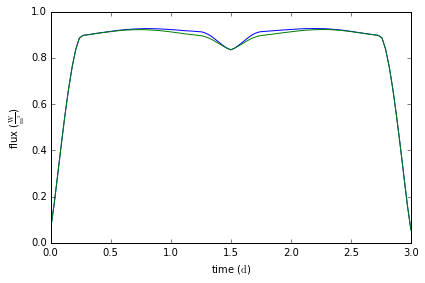

In [16]:
axs, artists = b.plot()

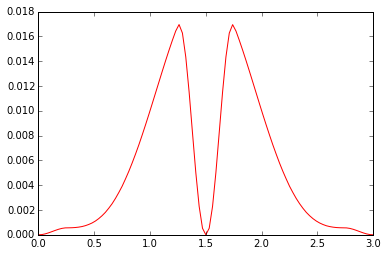

In [17]:
artists = plt.plot(b['value@times@refl_false'], b['value@fluxes@refl_true']-b['value@fluxes@refl_false'], 'r-')

Influence on Meshes (Intensities)
------------------------------------------

In [18]:
b.add_dataset('mesh', times=[1.2])

<ParameterSet: 2 parameters | contexts: compute, dataset>

In [19]:
b.run_compute(refl=False, delta=0.2, model='refl_false')

<ParameterSet: 64 parameters | kinds: mesh, lc>

In [20]:
b.run_compute(refl=True, delta=0.2, model='refl_true')

<ParameterSet: 64 parameters | kinds: mesh, lc>

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


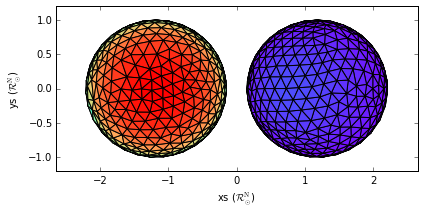

In [21]:
axs, artists = b.plot(kind='mesh', model='refl_false', facecolor='intensities')

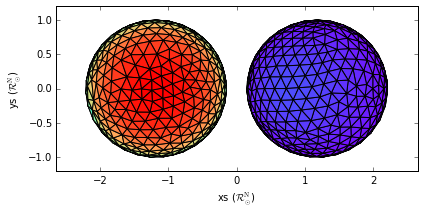

In [22]:
axs, artists = b.plot(kind='mesh', model='refl_true', facecolor='intensities')